In [ ]:
import os
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image, ImageFile

# Allow truncated images to be loaded
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ============= 1. SETUP KAGGLE API & DOWNLOAD DATA =============
from google.colab import files

print("Please upload your kaggle.json file:")
uploaded = files.upload()

# Configure Kaggle API credentials
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
os.rename("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
print("✓ Kaggle API configured")

# Download and unzip the dataset
print("\nDownloading Waste Segregation Dataset...")
!kaggle datasets download -d aashidutt3/waste-segregation-image-dataset -p ./waste_data --force
!unzip -qo ./waste_data/waste-segregation-image-dataset.zip -d ./waste_data
print("✓ Dataset downloaded and extracted successfully!")


# ============= 2. PREPARE DATA LOADERS =============
# Check for CPU/GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ** CORRECTED PATHS FOR COLAB ENVIRONMENT **
data_dir = './waste_data/Dataset'
train_data_path = os.path.join(data_dir, 'train')
test_data_path = os.path.join(data_dir, 'val')

# Create a custom dataset class to handle truncated images
class TruncatedImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except OSError as e:
            if "truncated" in str(e):
                print(f"Skipping truncated image at index {index}: {self.samples[index][0]}")
                # Return a dummy sample or skip the image
                # For simplicity, we'll skip and potentially reduce batch size
                # A more robust solution might involve finding a valid next index
                return None, None  # Indicate to skip this sample
            else:
                raise e # Re-raise other OS errors


# Load datasets using the custom ImageFolder
train_data = TruncatedImageFolder(root=train_data_path, transform=train_transform)
test_data = TruncatedImageFolder(root=test_data_path, transform=test_transform)

# Create DataLoaders with a custom collate function to handle skipped samples
def custom_collate_fn(batch):
    # Filter out None samples
    batch = [(images, labels) for images, labels in batch if images is not None]
    if not batch: # Return None if batch is empty after filtering
        return None, None
    return torch.utils.data.dataloader.default_collate(batch)


trainDataLoader = DataLoader(dataset=train_data, batch_size=64, shuffle=True, collate_fn=custom_collate_fn)
testDataLoader = DataLoader(dataset=test_data, batch_size=32, shuffle=False, collate_fn=custom_collate_fn) # No need to shuffle test data


# ============= 3. DEFINE THE MODEL =============
# Load Pre-trained model (using updated weights parameter)
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze feature parameters
for param in model.parameters():
    param.requires_grad = False

# Define a new custom classifier
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(2048, 512)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(p=0.2)),
    ('fc2', nn.Linear(512, 2)), # We have 2 classes: biodegradable and non_biodegradable
    ('output', nn.LogSoftmax(dim=1))
]))

# Replace the model's classifier
model.fc = classifier


# ============= 4. TRAIN THE MODEL =============
model.to(device)

# Hyperparameters
epochs = 10
criterion = nn.NLLLoss()
optimizer = optim.Adam(params=model.fc.parameters(), lr=0.001)

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], [] # Added to store accuracies

print("\nStarting Model Training...")
# ------------- Main Training Loop ------------
for e in range(epochs):
    running_loss = 0
    running_accuracy = 0 # Added to track training accuracy
    # ------------- Training Batch Loop -----------
    model.train() # Set model to training mode
    for images, labels in trainDataLoader:
        if images is None: # Skip if the batch is empty after filtering
            continue

        # Move data to the appropriate device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model.forward(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        ps = torch.exp(outputs)
        top_k, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        running_accuracy += torch.mean(equals.type(torch.FloatTensor))

    # ------------ Validation Loop -----------
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval() # Set model to evaluation mode
            for images, labels in testDataLoader:
                if images is None: # Skip if the batch is empty after filtering
                    continue
                images, labels = images.to(device), labels.to(device)

                logps = model.forward(images)
                test_loss += criterion(logps, labels)

                # Calculate accuracy
                ps = torch.exp(logps)
                top_k, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        # Store losses
        # Ensure we don't divide by zero if DataLoader is empty after filtering
        train_loss_avg = running_loss / len(trainDataLoader) if len(trainDataLoader) > 0 else 0
        train_accuracy_avg = running_accuracy / len(trainDataLoader) if len(trainDataLoader) > 0 else 0 # Stored training accuracy
        test_loss_avg = test_loss.item() / len(testDataLoader) if len(testDataLoader) > 0 else 0
        test_accuracy_avg = accuracy / len(testDataLoader) if len(testDataLoader) > 0 else 0 # Stored test accuracy


        train_losses.append(train_loss_avg)
        train_accuracies.append(train_accuracy_avg) # Append training accuracy
        test_losses.append(test_loss_avg)
        test_accuracies.append(test_accuracy_avg) # Append test accuracy

        print(f"Epoch: {e + 1}/{epochs} | "
              f"Training Loss: {train_loss_avg:.3f} | Training Accuracy: {train_accuracy_avg:.3f} | "
              f"Test Loss: {test_loss_avg:.3f} | "
              f"Test Accuracy: {test_accuracy_avg:.3f}")

print("\nTraining Done!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
✓ Kaggle API configured

Dataset URL: https://www.kaggle.com/datasets/aashidutt3/waste-segregation-image-dataset
License(s): CC-BY-NC-SA-4.0
 99% 1.15G/1.17G [00:05<00:00, 206MB/s]
100% 1.17G/1.17G [00:05<00:00, 216MB/s]
✓ Dataset downloaded and extracted successfully!

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]



Starting Model Training...


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1/10 | Training Loss: 0.070 | Training Accuracy: 0.974 | Test Loss: 0.098 | Test Accuracy: 0.962
Epoch: 2/10 | Training Loss: 0.030 | Training Accuracy: 0.989 | Test Loss: 0.112 | Test Accuracy: 0.960
Epoch: 3/10 | Training Loss: 0.026 | Training Accuracy: 0.990 | Test Loss: 0.090 | Test Accuracy: 0.964
Epoch: 4/10 | Training Loss: 0.020 | Training Accuracy: 0.992 | Test Loss: 0.087 | Test Accuracy: 0.966
Epoch: 5/10 | Training Loss: 0.018 | Training Accuracy: 0.993 | Test Loss: 0.100 | Test Accuracy: 0.965
Epoch: 6/10 | Training Loss: 0.014 | Training Accuracy: 0.994 | Test Loss: 0.090 | Test Accuracy: 0.969
Epoch: 7/10 | Training Loss: 0.013 | Training Accuracy: 0.995 | Test Loss: 0.105 | Test Accuracy: 0.969
Epoch: 8/10 | Training Loss: 0.013 | Training Accuracy: 0.995 | Test Loss: 0.136 | Test Accuracy: 0.960
Epoch: 9/10 | Training Loss: 0.010 | Training Accuracy: 0.996 | Test Loss: 0.113 | Test Accuracy: 0.967
Epoch: 10/10 | Training Loss: 0.010 | Training Accuracy: 0.996 |

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

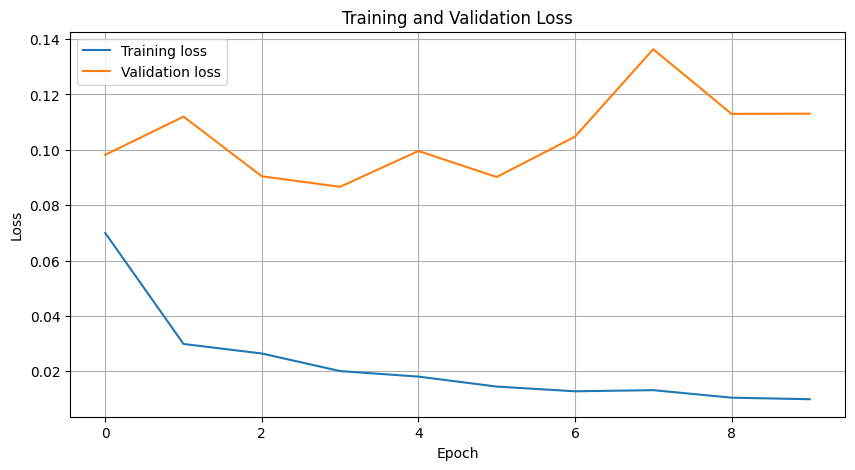

In [ ]:
import matplotlib.pyplot as plt

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

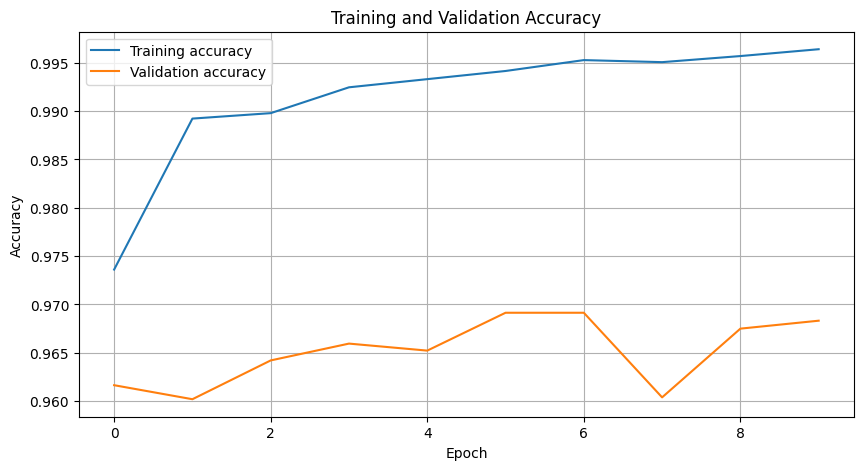

In [ ]:
import matplotlib.pyplot as plt

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot([t.cpu().numpy() for t in train_accuracies], label='Training accuracy')
plt.plot([t.cpu().numpy() for t in test_accuracies], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()